In [75]:
# hack to import local classes
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

from src.models import train_model
from src.data import read_transform
from sklearn.metrics import calinski_harabaz_score

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Read CSR matrix from the input file
csrMatrix = read_transform.csr_read('../data/raw/train.dat')

#Scale the CSR matrix by idf (Inverse Document Frequency)
csrIDF = read_transform.csr_idf(csrMatrix, copy=True)

#Normalize the rows of a CSR matrix by their L-2 norm.
csrL2Normalized = read_transform.csr_l2normalize(csrIDF, copy=True)

#Obtain a dense ndarray representation of the CSR matrix.
denseMatrix = csrL2Normalized.toarray()

In [3]:
from sklearn.decomposition import TruncatedSVD

In [4]:
pca = TruncatedSVD(2)

In [5]:
csrL2Normalized_pca = pca.fit_transform(csrL2Normalized)

In [10]:
dfPca = pd.DataFrame(csrL2Normalized_pca)

In [14]:
dfPca.columns

RangeIndex(start=0, stop=2, step=1)

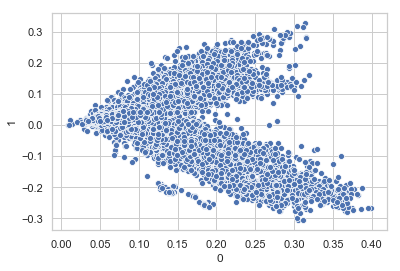

In [15]:
sns.scatterplot(dfPca[0], dfPca[1])

In [16]:
from sklearn.cluster import DBSCAN

In [36]:
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')

In [37]:
dbscan.fit(csrL2Normalized)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=2, n_jobs=None, p=None)

In [38]:
calinski_harabaz_score(csrL2Normalized.toarray(), dbscan.labels_)

3.199150871559861

In [42]:
epss = list()
chscores = list()
for i in range(1,10, 1):
    eps = i/10
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    dbscan.fit(csrL2Normalized)
    chscore = calinski_harabaz_score(denseMatrix, dbscan.labels_)
    print ("eps= %f CH Score = %f" %(eps, chscore))
    epss.append(eps)
    chscores.append(chscore)

eps= 0.100000 CH Score = 3.180422
eps= 0.200000 CH Score = 2.905354
eps= 0.300000 CH Score = 2.685392
eps= 0.400000 CH Score = 2.787182
eps= 0.500000 CH Score = 3.199151
eps= 0.600000 CH Score = 2.227343
eps= 0.700000 CH Score = 1.913004
eps= 0.800000 CH Score = 1.806548
eps= 0.900000 CH Score = 1.581041


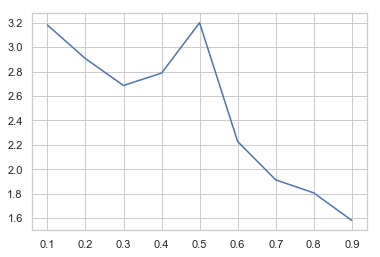

In [43]:
sns.lineplot(epss, chscores)

In [44]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')

In [47]:
dbscan.fit(csrL2Normalized)

KeyboardInterrupt: 

In [46]:
calinski_harabaz_score(csrL2Normalized.toarray(), dbscan.labels_)

6.596177416659544

In [52]:
epss = list()
min_samps = list()
chscores = list()
labs = list()
for i in range(3,8, 2):
    for j in range(5,50,10):
        eps = i/10
        min_samp = j
        dbscan = DBSCAN(eps=eps, min_samples=min_samp, metric='cosine')
        dbscan.fit(csrL2Normalized)
        chscore = 0
        if len(set(dbscan.labels_)) > 1:
            chscore = calinski_harabaz_score(denseMatrix, dbscan.labels_)
        print ("eps=%f min_samples=%d CHScore=%f" %(eps, min_samp, chscore))
        epss.append(eps)
        min_samps.append(min_samp)
        chscores.append(chscore)
        labs.append(dbscan.labels_)

eps=0.300000 min_samples=5 CHScore=8.695441
eps=0.300000 min_samples=15 CHScore=33.033627
eps=0.300000 min_samples=25 CHScore=32.803540
eps=0.300000 min_samples=35 CHScore=32.803540
eps=0.300000 min_samples=45 CHScore=0.000000
eps=0.500000 min_samples=5 CHScore=6.596177
eps=0.500000 min_samples=15 CHScore=16.894417
eps=0.500000 min_samples=25 CHScore=23.069671
eps=0.500000 min_samples=35 CHScore=28.478509
eps=0.500000 min_samples=45 CHScore=34.644323
eps=0.700000 min_samples=5 CHScore=3.748321
eps=0.700000 min_samples=15 CHScore=9.323117
eps=0.700000 min_samples=25 CHScore=12.471623
eps=0.700000 min_samples=35 CHScore=16.831819
eps=0.700000 min_samples=45 CHScore=25.648293


In [53]:
np.argmax(chscores)

9

In [54]:
chscores[9]

34.6443226652078

In [56]:
pd.DataFrame(labs[9])[0].value_counts()

-1    8480
 0      55
 1      45
Name: 0, dtype: int64

In [57]:
dfPca['labels'] = labs[9]

In [61]:
dfPca = dfPca.rename(index=str, columns={0: "x", 1: "y", "labels":"labels"})

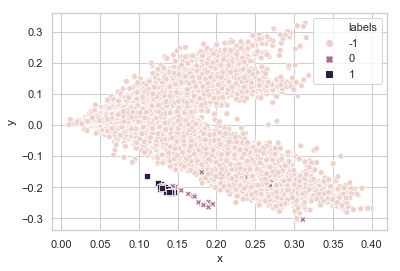

In [62]:
sns.scatterplot(x="x", y="y",hue="labels", style="labels", data=dfPca)

In [63]:
from sklearn.cluster import KMeans

In [64]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, random_state=10, n_jobs=-1)

In [65]:
km.fit(csrL2Normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [68]:
dfPca['km_labels'] = km.labels_ + 1

In [71]:
dfPca = dfPca.rename(index=str, columns={"labels":"db_labels"})

In [76]:
bm_labels = train_model.bisecting_kmeans(denseMatrix, 7, 10)

In [77]:
dfPca['bm_labels'] = bm_labels

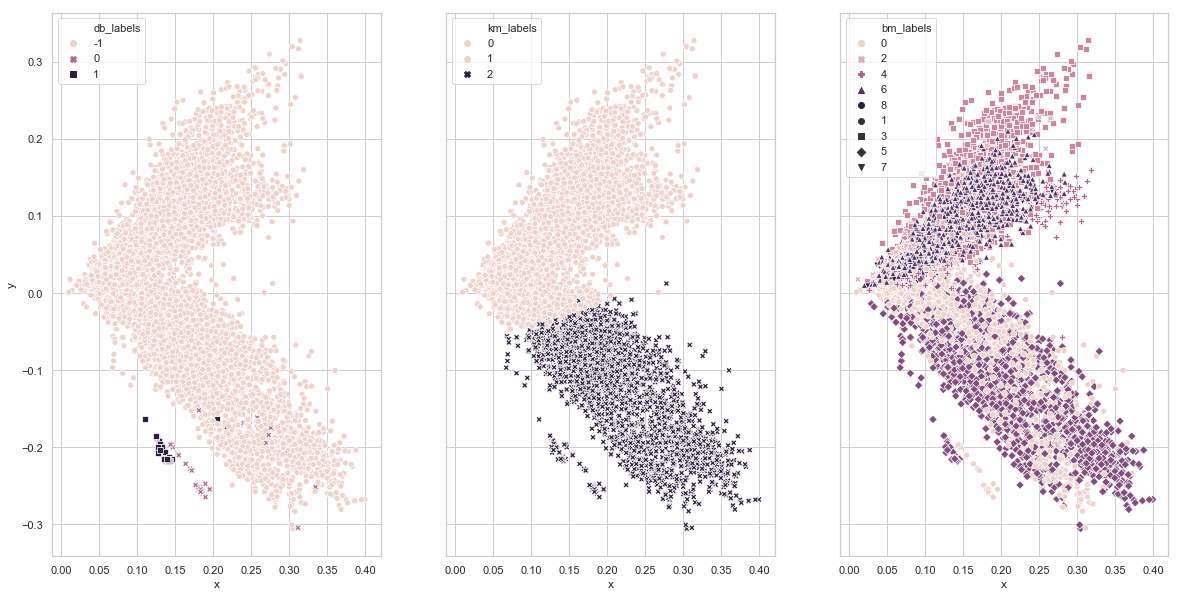

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,10))
sns.scatterplot(x="x", y="y",hue="db_labels", style="db_labels", data=dfPca, ax=ax1)
sns.scatterplot(x="x", y="y",hue="km_labels", style="km_labels", data=dfPca, ax=ax2)
sns.scatterplot(x="x", y="y",hue="bm_labels", style="bm_labels", data=dfPca, ax=ax3)